In [1]:
import os
import sys
import logging
from pathlib import Path

# --- Setup Project Root and Python Path ---
current_dir = Path().resolve()
project_root = next((p for p in [current_dir, current_dir.parent] if (p / 'src').exists()), None)
if not project_root: raise FileNotFoundError("Could not find 'src' directory.")
if str(project_root) not in sys.path: sys.path.insert(0, str(project_root))
os.environ['PYTHONPATH'] = str(project_root)

# --- Import Project Modules ---
from src.utils.config_validator import load_and_merge_configs, print_config_summary
from src.data.dataset_manager import DatasetManager
from src.training.model_manager import ModelManager
from src.training.progressive_trainer import ProgressiveTrainer
from src.evaluation.evaluator import Evaluator
from ultralytics import YOLO
from IPython.display import Image as IPyImage, display
import random
import torch
from PIL import Image
import matplotlib.pyplot as plt
from src.data.augmentation import create_rand_augment_transform

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] [%(name)s] - %(message)s')
logger = logging.getLogger("Two_Stage_Notebook")

### STAGE 1: TRAIN THE DETECTION HEAD

In [2]:
logger.info("="*80)
logger.info("▶️ CONFIGURING STAGE 1: TRAIN HEAD")
logger.info("="*80)

BASE_CONFIG_PATH = project_root / 'configs' / 'base_config.yaml'
STAGE1_CONFIG_PATH = project_root / 'configs' / 'task2_stage1.yaml'

config_s1 = load_and_merge_configs(str(BASE_CONFIG_PATH), str(STAGE1_CONFIG_PATH))
print_config_summary(config_s1)

2025-09-26 04:48:55,184 - INFO - ================================================================================
2025-09-26 04:48:55,184 - INFO - ▶️ CONFIGURING STAGE 1: TRAIN HEAD
2025-09-26 04:48:55,185 - INFO - ================================================================================
2025-09-26 04:48:55,191 - INFO - ✅ Configurations merged: /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/configs/base_config.yaml + /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/configs/task2_stage1.yaml
2025-09-26 04:48:55,191 - INFO - 📋 Configuration Summary:
2025-09-26 04:48:55,191 - INFO -   Model: yolo11n.pt
2025-09-26 04:48:55,192 - INFO -   Classes: 85
2025-09-26 04:48:55,192 - INFO -   Device: 0,1
2025-09-26 04:48:55,192 - INFO -   Batch Size: 512
2025-09-26 04:48:55,192 - INFO -   Epochs: 75
2025-09-26 04:48:55,192 - INFO -   Image Size: 640
2025-09-26 04:48:55,193 - INFO -   Seed: 42
2025-09-26 04:48:55,193 - INFO -   Learning Rate: 0.001 (scaled from 0.0001 for batch size 512)
2025-09-

In [3]:
logger.info("💾 Initializing and preparing datasets (this will only run once)...")
data_manager = DatasetManager(config_s1)
data_manager.setup_datasets(task_type='task2')
logger.info("✅ DatasetManager setup is complete.")


2025-09-26 04:48:55,199 - INFO - 💾 Initializing and preparing datasets (this will only run once)...
2025-09-26 04:48:56,804 - INFO - 🌱 Random seeds set to 42 for reproducibility.
2025-09-26 04:48:56,804 - INFO - 🚀 Starting dataset setup for task: 'task2'...
2025-09-26 04:48:56,805 - INFO - ✨ Performing first-time setup for the dataset.
2025-09-26 04:48:56,808 - INFO - Downloading 'coco_143_sample.zip' from Hugging Face repo 'VivekChandra/COCO_143'...


coco_143_sample.zip:   0%|          | 0.00/1.86G [00:00<?, ?B/s]

2025-09-26 04:49:04,095 - INFO - Extracting 'coco_143_sample.zip' to outputs/datasets/coco_source...
2025-09-26 04:53:00,893 - INFO - Extraction complete for 'VivekChandra/COCO_143'.
2025-09-26 04:53:00,905 - INFO - Downloading 'HomeObjects-3K_5class_29_per_class.zip' from Hugging Face repo 'VivekChandra/HomeObjects-3K_5class_29_per_class'...


HomeObjects-3K_5class_29_per_class.zip:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

2025-09-26 04:53:01,251 - INFO - Extracting 'HomeObjects-3K_5class_29_per_class.zip' to outputs/datasets/homeobjects_source/task2...
2025-09-26 04:53:03,752 - INFO - Extraction complete for 'VivekChandra/HomeObjects-3K_5class_29_per_class'.
2025-09-26 04:53:03,754 - INFO - Scanning for novel training images in: outputs/datasets/homeobjects_source/task2/images/train
2025-09-26 04:53:03,756 - INFO - ✅ Found 100 novel training image filenames.
2025-09-26 04:53:03,756 - INFO - 💿 Creating combined dataset on disk...
2025-09-26 04:53:03,756 - INFO -   - Processing 'train' split...
2025-09-26 04:55:38,396 - INFO -   - Processing 'val' split...
2025-09-26 04:56:15,745 - INFO -   - Processing 'test' split...
2025-09-26 04:56:31,936 - INFO - Master dataset YAML created at: outputs/combined_dataset/task2/dataset.yaml
2025-09-26 04:56:31,937 - INFO - ✅ First-time dataset setup complete.
2025-09-26 04:56:31,938 - INFO - ✅ DatasetManager setup is complete.


In [4]:
logger.info("="*80)
logger.info("▶️ EXECUTING STAGE 1: TRAIN HEAD")
logger.info("="*80)

model_manager_s1 = ModelManager(config_s1, data_manager)
trainer_s1 = ProgressiveTrainer(config_s1, data_manager, model_manager_s1)
model_s1 = trainer_s1.run_training()

2025-09-26 04:56:31,989 - INFO - ================================================================================
2025-09-26 04:56:31,989 - INFO - ▶️ EXECUTING STAGE 1: TRAIN HEAD
2025-09-26 04:56:31,990 - INFO - ================================================================================
2025-09-26 04:56:31,990 - INFO - ModelManager initialized on device 'cuda:0'.
2025-09-26 04:56:31,990 - INFO - Loading pre-trained model: yolo11n.pt...
2025-09-26 04:56:32,286 - INFO - Freezing the first 20 layers of the model backbone...
2025-09-26 04:56:32,289 - INFO - Successfully froze 20 layers.
2025-09-26 04:56:32,290 - INFO - ✅ Model 'yolo11n.pt' is configured and ready for training.
2025-09-26 04:56:32,291 - INFO - --- Model Parameters ---
2025-09-26 04:56:32,291 - INFO -   - Total:     2,624,080
2025-09-26 04:56:32,292 - INFO -   - Trainable: 991,504
2025-09-26 04:56:32,292 - INFO -   - Frozen:    1,632,576
2025-09-26 04:56:32,292 - INFO - ------------------------
2025-09-26 04:56:32,296 

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_5.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fals

Exception in thread Thread-2 (_pin_memory_loop):
Traceback (most recent call last):
  File "/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/threading.py", line 1016, in _bootstrap_inner


YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.9it/s 5.8s1.7ss
                   all       2350      21757      0.526      0.378      0.388      0.254
                person       1264       5309      0.692      0.652      0.686      0.433
               bicycle         79        128      0.582      0.508      0.521       0.31
                   car        263        885       0.54      0.449      0.449      0.265
            motorcycle         65        188      0.579      0.482      0.489      0.254
              airplane         37         59      0.684      0.542      0.569      0.347
                   bus         77        126      0.718      0.579      0.622      0.471
                 train         53         74      0.689      0.595      0.632      0.426
                 truck        133        201      0.403      0.403      0.3

2025-09-26 05:20:50,071 - INFO - --- Processing results for Phase 1 with custom evaluation ---
2025-09-26 05:20:50,076 - INFO - Loading best model from Phase 1 for detailed evaluation...
2025-09-26 05:20:50,102 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 652.5±120.3 MB/s, size: 178.8 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 1.9Kit/s 0.6s1ss
val: New cache created: /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.4it/s 11.1s1.8s
                   all       1135      10405      0.538      0.374      0.474      0.335
                person        582       2451      0.732      0.664      0.744      0.512
               bicycle         35         80      0.492      0.375      0.458      0.258
                   car        114        431      0.604      0.473      0.557      0.368
            motorcycle         32        101      0.812      0.386      0.618      0.375
              airplane         19         30       0.64      0.533      0.611      0.481
                   bus         34         47      0.659      0.617      0.714      0.641
                 train         24         32       0.81      0.531       0.69      0.522
                 truck         63        103      0.388       0.32      0.329      0.242
                  boat         21         74        0.5      0.365   

2025-09-26 05:21:06,566 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 05:21:06,583 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5034        0.0000  0.4738
mAP@50-95       0.3562        0.0000  0.3352
2025-09-26 05:21:06,584 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       50.34%         0.00%  47.38%
mAP@50-95       35.62%         0.00%  33.52%
2025-09-26 05:21:06,584 - INFO - ✅ Final evaluation complete.
2025-09-26 05:21:06,585 - INFO - Phase 1 Model Perf: Base mAP=0.5034, Novel mAP=0.0000
2025-09-26 05:21:06,585 - INFO - ✅ Base mAP (0.5034) PASSED the safety net (0.4000).
2025-09-26 05:21:06,585 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 05:21:06,586 - INFO - Novel mAP improved from -1.0000 to 0.0000
2025-09-26 05:21:06,586 - INFO - 
🚀 Starting Phase 2/6
2025-09-26 05:21:06,586 - INFO - 📝 Creating phas

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_10.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fal

2025-09-26 05:43:46,452 - INFO - --- Processing results for Phase 2 with custom evaluation ---
2025-09-26 05:43:46,455 - INFO - Loading best model from Phase 2 for detailed evaluation...
2025-09-26 05:43:46,481 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 595.9±85.1 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 3.3Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.5it/s 9.3s2.1ss
                   all       1135      10405      0.553      0.378      0.481      0.341
                person        582       2451      0.732      0.656       0.74      0.509
               bicycle         35         80      0.648      0.438      0.586      0.339
                   car        114        431      0.629      0.457      0.557      0.358
            motorcycle         32        101      0.726      0.446      0.612      0.362
              airplane         19         30      0.857        0.6      0.764      0.523
                   bus         34         47      0.727      0.681      0.777      0.687
                 train         24         32      0.613      0.594      0.644      0.424
                 truck         63        103       0.51      0.252      0.371      0.272
                  boat         21         74      0.605      0.311   

2025-09-26 05:43:58,517 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 05:43:58,520 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5029        0.1319  0.4810
mAP@50-95       0.3562        0.1012  0.3412
2025-09-26 05:43:58,521 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       50.29%        13.19%  48.10%
mAP@50-95       35.62%        10.12%  34.12%
2025-09-26 05:43:58,522 - INFO - ✅ Final evaluation complete.
2025-09-26 05:43:58,522 - INFO - Phase 2 Model Perf: Base mAP=0.5029, Novel mAP=0.1319
2025-09-26 05:43:58,522 - INFO - ✅ Base mAP (0.5029) PASSED the safety net (0.4000).
2025-09-26 05:43:58,523 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 05:43:58,523 - INFO - Novel mAP improved from 0.0000 to 0.1319
2025-09-26 05:43:58,524 - INFO - 
🚀 Starting Phase 3/6
2025-09-26 05:43:58,524 - INFO - 📝 Creating phase

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_25.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fal

2025-09-26 06:03:30,265 - INFO - --- Processing results for Phase 3 with custom evaluation ---
2025-09-26 06:03:30,270 - INFO - Loading best model from Phase 3 for detailed evaluation...
2025-09-26 06:03:30,297 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 709.6±106.4 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.1Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.5it/s 9.2s2.4ss
                   all       1135      10405      0.562      0.353      0.471      0.336
                person        582       2451      0.757      0.665      0.751      0.515
               bicycle         35         80      0.682      0.375      0.553      0.334
                   car        114        431      0.591      0.439      0.522       0.35
            motorcycle         32        101      0.724      0.416      0.602      0.367
              airplane         19         30      0.762      0.533      0.711      0.496
                   bus         34         47      0.705       0.66      0.741       0.65
                 train         24         32      0.667      0.438      0.609       0.46
                 truck         63        103      0.438      0.272      0.352      0.257
                  boat         21         74      0.442      0.257   

2025-09-26 06:03:42,753 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 06:03:42,756 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4966        0.0569  0.4707
mAP@50-95       0.3542        0.0398  0.3357
2025-09-26 06:03:42,757 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       49.66%         5.69%  47.07%
mAP@50-95       35.42%         3.98%  33.57%
2025-09-26 06:03:42,757 - INFO - ✅ Final evaluation complete.
2025-09-26 06:03:42,758 - INFO - Phase 3 Model Perf: Base mAP=0.4966, Novel mAP=0.0569
2025-09-26 06:03:42,758 - INFO - ✅ Base mAP (0.4966) PASSED the safety net (0.4000).
2025-09-26 06:03:42,758 - INFO - Novel mAP (0.0569) did not improve upon the best of 0.1319.
2025-09-26 06:03:42,758 - INFO - 
🚀 Starting Phase 4/6
2025-09-26 06:03:42,759 - INFO - 📝 Creating phase-specific YAML (novel_ratio=0.50)...
2025-09-26 06:0

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_50.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fal

2025-09-26 06:18:20,630 - INFO - --- Processing results for Phase 4 with custom evaluation ---
2025-09-26 06:18:20,634 - INFO - Loading best model from Phase 4 for detailed evaluation...
2025-09-26 06:18:20,663 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 717.5±111.6 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.4Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 7.8s2.3ss
                   all       1135      10405      0.577      0.346      0.472      0.333
                person        582       2451      0.769      0.644      0.742       0.51
               bicycle         35         80      0.708      0.425       0.59      0.324
                   car        114        431      0.613      0.455      0.545       0.35
            motorcycle         32        101       0.75      0.327      0.563      0.361
              airplane         19         30      0.842      0.533       0.72      0.457
                   bus         34         47      0.812      0.553      0.727      0.658
                 train         24         32      0.833      0.469      0.689      0.451
                 truck         63        103      0.377      0.252        0.3      0.219
                  boat         21         74      0.457      0.284   

2025-09-26 06:18:32,095 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 06:18:32,099 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4925        0.1458  0.4721
mAP@50-95       0.3461        0.1194  0.3327
2025-09-26 06:18:32,100 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       49.25%        14.58%  47.21%
mAP@50-95       34.61%        11.94%  33.27%
2025-09-26 06:18:32,101 - INFO - ✅ Final evaluation complete.
2025-09-26 06:18:32,101 - INFO - Phase 4 Model Perf: Base mAP=0.4925, Novel mAP=0.1458
2025-09-26 06:18:32,101 - INFO - ✅ Base mAP (0.4925) PASSED the safety net (0.4000).
2025-09-26 06:18:32,102 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 06:18:32,102 - INFO - Novel mAP improved from 0.1319 to 0.1458
2025-09-26 06:18:32,102 - INFO - 
🚀 Starting Phase 5/6
2025-09-26 06:18:32,102 - INFO - 📝 Creating phase

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_75.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fal

2025-09-26 06:27:59,068 - INFO - --- Processing results for Phase 5 with custom evaluation ---
2025-09-26 06:27:59,072 - INFO - Loading best model from Phase 5 for detailed evaluation...
2025-09-26 06:27:59,099 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 716.0±105.8 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.4Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.8s2.3ss
                   all       1135      10405       0.54      0.336      0.448      0.314
                person        582       2451      0.724      0.638      0.726      0.493
               bicycle         35         80      0.578      0.325      0.496      0.325
                   car        114        431      0.651      0.385      0.524       0.35
            motorcycle         32        101       0.84      0.416      0.647      0.395
              airplane         19         30      0.727      0.533      0.689       0.45
                   bus         34         47       0.75      0.574      0.726      0.633
                 train         24         32      0.577      0.469      0.577      0.453
                 truck         63        103      0.377      0.252      0.288      0.199
                  boat         21         74      0.615      0.216   

2025-09-26 06:28:11,217 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 06:28:11,220 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4608        0.2430  0.4480
mAP@50-95       0.3225        0.1809  0.3142
2025-09-26 06:28:11,222 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       46.08%        24.30%  44.80%
mAP@50-95       32.25%        18.09%  31.42%
2025-09-26 06:28:11,222 - INFO - ✅ Final evaluation complete.
2025-09-26 06:28:11,222 - INFO - Phase 5 Model Perf: Base mAP=0.4608, Novel mAP=0.2430
2025-09-26 06:28:11,223 - INFO - ✅ Base mAP (0.4608) PASSED the safety net (0.4000).
2025-09-26 06:28:11,223 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 06:28:11,223 - INFO - Novel mAP improved from 0.1458 to 0.2430
2025-09-26 06:28:11,223 - INFO - 
🚀 Starting Phase 6/6
2025-09-26 06:28:11,224 - INFO - 📝 Creating phase

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_90.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fal

2025-09-26 06:34:35,654 - INFO - --- Processing results for Phase 6 with custom evaluation ---
2025-09-26 06:34:35,658 - INFO - Loading best model from Phase 6 for detailed evaluation...
2025-09-26 06:34:35,685 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 746.4±113.9 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.4Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.7it/s 7.6s1.9ss
                   all       1135      10405      0.686       0.18      0.435      0.312
                person        582       2451      0.903      0.433      0.674      0.498
               bicycle         35         80        0.7      0.175      0.448      0.286
                   car        114        431      0.844      0.125      0.485       0.38
            motorcycle         32        101          1      0.119      0.559      0.366
              airplane         19         30      0.895      0.567      0.732      0.507
                   bus         34         47      0.958      0.489      0.734       0.63
                 train         24         32      0.857      0.375      0.643      0.391
                 truck         63        103       0.55      0.107      0.327      0.232
                  boat         21         74      0.889      0.108   

2025-09-26 06:34:46,743 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 06:34:46,746 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4522        0.1590  0.4350
mAP@50-95       0.3232        0.1309  0.3119
2025-09-26 06:34:46,747 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       45.22%        15.90%  43.50%
mAP@50-95       32.32%        13.09%  31.19%
2025-09-26 06:34:46,748 - INFO - ✅ Final evaluation complete.
2025-09-26 06:34:46,748 - INFO - Phase 6 Model Perf: Base mAP=0.4522, Novel mAP=0.1590
2025-09-26 06:34:46,748 - INFO - ✅ Base mAP (0.4522) PASSED the safety net (0.4000).
2025-09-26 06:34:46,749 - INFO - Novel mAP (0.1590) did not improve upon the best of 0.2430.
2025-09-26 06:34:46,749 - INFO - 🏆 Saving overall best model from /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/runs/task_20shot_stage1_train_head_p

2025-09-26 06:34:55,611 - INFO - ================================================================================
2025-09-26 06:34:55,611 - INFO - ▶️ ANALYZING STAGE 1 RESULTS
2025-09-26 06:34:55,612 - INFO - ================================================================================
2025-09-26 06:34:55,612 - INFO - Displaying training summary plot for Stage 1 from: outputs/training_summary_plots_task_20shot_stage1_train_head.png


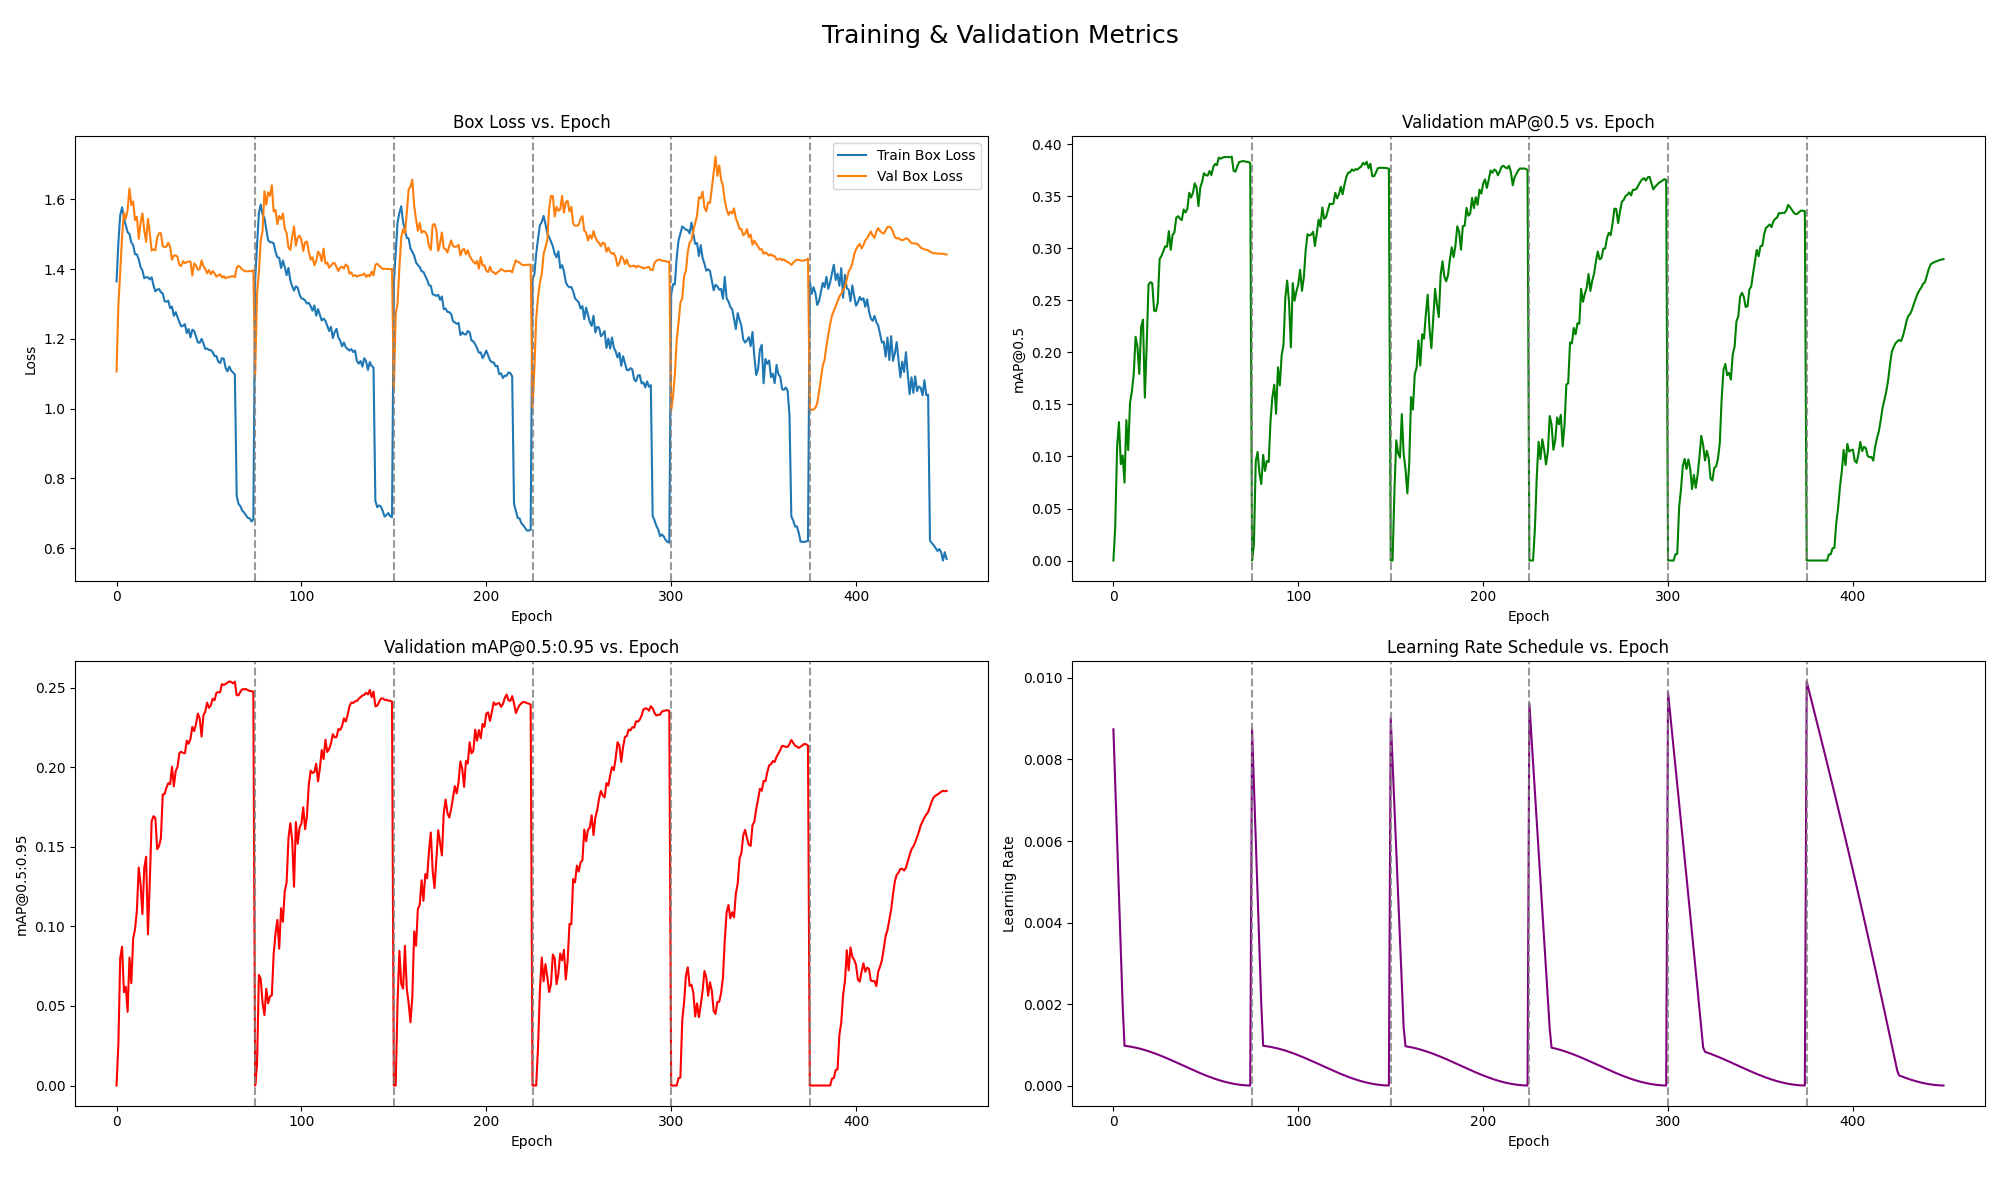

2025-09-26 06:34:55,617 - INFO - Loading best model from Stage 1: /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/runs/task_20shot_stage1_train_head_phase_5/weights/best.pt
2025-09-26 06:34:55,706 - INFO - Evaluator initialized for 80 base and 5 novel classes.
2025-09-26 06:34:55,706 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 532.1±182.5 MB/s, size: 143.9 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.4Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.3s2.0ss
                   all       1135      10405       0.54      0.336      0.448      0.314
                person        582       2451      0.724      0.638      0.726      0.493
               bicycle         35         80      0.578      0.325      0.496      0.325
                   car        114        431      0.651      0.385      0.524       0.35
            motorcycle         32        101       0.84      0.416      0.647      0.395
              airplane         19         30      0.727      0.533      0.689       0.45
                   bus         34         47       0.75      0.574      0.726      0.633
                 train         24         32      0.577      0.469      0.577      0.453
                 truck         63        103      0.377      0.252      0.288      0.199
                  boat         21         74      0.615      0.216   

2025-09-26 06:35:07,803 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 06:35:07,806 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4608        0.2430  0.4480
mAP@50-95       0.3225        0.1809  0.3142
2025-09-26 06:35:07,807 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       46.08%        24.30%  44.80%
mAP@50-95       32.25%        18.09%  31.42%
2025-09-26 06:35:07,807 - INFO - ✅ Final evaluation complete.


In [5]:
logger.info("="*80)
logger.info("▶️ ANALYZING STAGE 1 RESULTS")
logger.info("="*80)

# --- Display Stage 1 Training Summary Plot ---
output_dir_s1 = Path(config_s1['output_dir'])
plot_path_s1 = output_dir_s1 / f"training_summary_plots_{config_s1['task_name']}.png"
if plot_path_s1.exists():
    logger.info(f"Displaying training summary plot for Stage 1 from: {plot_path_s1}")
    display(IPyImage(filename=str(plot_path_s1)))
else:
    logger.warning(f"Could not find Stage 1 summary plot at {plot_path_s1}")

# --- Evaluate the Stage 1 Model ---
stage1_best_model_path = trainer_s1.overall_best_model_path
if stage1_best_model_path and stage1_best_model_path.exists():
    logger.info(f"Loading best model from Stage 1: {stage1_best_model_path}")
    final_model_s1 = YOLO(str(stage1_best_model_path))
    
    evaluator_s1 = Evaluator(config_s1, data_manager)
    evaluator_s1.evaluate_model(final_model_s1)
else:
    logger.error("Could not find the best model from Stage 1. Halting.")


In [6]:
# Cleanup GPU Memory After Stage 1

import torch
import gc

# Delete the large model and trainer objects from Stage 1
del model_s1
del trainer_s1
del model_manager_s1

# Run the garbage collector and empty the CUDA cache
gc.collect()
torch.cuda.empty_cache()

logger.info("✅ Cleaned up Stage 1 objects and cleared GPU cache.")

2025-09-26 06:35:55,824 - INFO - ✅ Cleaned up Stage 1 objects and cleared GPU cache.


## STAGE 2: FINE-TUNE THE MODEL

In [7]:
logger.info("="*80)
logger.info("▶️ CONFIGURING STAGE 2: FINE-TUNE MODEL")
logger.info("="*80)

STAGE2_CONFIG_PATH = project_root / 'configs' / 'task2_stage2.yaml'
config_s2 = load_and_merge_configs(str(BASE_CONFIG_PATH), str(STAGE2_CONFIG_PATH))

# --- Automatically update config with the model from Stage 1 ---
if 'stage1_best_model_path' in locals() and stage1_best_model_path:
    config_s2['model_name'] = str(stage1_best_model_path)
    logger.info(f"Stage 2 will start from model: {config_s2['model_name']}")
else:
    raise FileNotFoundError("Cannot proceed to Stage 2 without a model from Stage 1.")

print_config_summary(config_s2)

2025-09-26 06:36:55,617 - INFO - ================================================================================
2025-09-26 06:36:55,618 - INFO - ▶️ CONFIGURING STAGE 2: FINE-TUNE MODEL
2025-09-26 06:36:55,618 - INFO - ================================================================================
2025-09-26 06:36:55,754 - INFO - ✅ Configurations merged: /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/configs/base_config.yaml + /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/configs/task2_stage2.yaml
2025-09-26 06:36:55,754 - INFO - Stage 2 will start from model: /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/runs/task_20shot_stage1_train_head_phase_5/weights/best.pt
2025-09-26 06:36:55,755 - INFO - 📋 Configuration Summary:
2025-09-26 06:36:55,755 - INFO -   Model: /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/runs/task_20shot_stage1_train_head_phase_5/weights/best.pt
2025-09-26 06:36:55,755 - INFO -   Classes: 85
2025-09-26 06:36:55,756 - INFO -   Device: 0,1
2025-09-26 0

In [8]:
logger.info("="*80)
logger.info("▶️ EXECUTING STAGE 2: FINE-TUNE MODEL")
logger.info("="*80)

model_manager_s2 = ModelManager(config_s2, data_manager)
trainer_s2 = ProgressiveTrainer(config_s2, data_manager, model_manager_s2)
final_model = trainer_s2.run_training()

2025-09-26 06:37:55,568 - INFO - ================================================================================
2025-09-26 06:37:55,569 - INFO - ▶️ EXECUTING STAGE 2: FINE-TUNE MODEL
2025-09-26 06:37:55,569 - INFO - ================================================================================
2025-09-26 06:37:55,570 - INFO - ModelManager initialized on device 'cuda:0'.
2025-09-26 06:37:55,570 - INFO - Loading pre-trained model: /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/runs/task_20shot_stage1_train_head_phase_5/weights/best.pt...
2025-09-26 06:37:55,597 - INFO - Freezing the first 18 layers of the model backbone...
2025-09-26 06:37:55,599 - INFO - Successfully froze 18 layers.
2025-09-26 06:37:55,599 - INFO - ✅ Model '/N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/runs/task_20shot_stage1_train_head_phase_5/weights/best.pt' is configured and ready for training.
2025-09-26 06:37:55,600 - INFO - --- Model Parameters ---
2025-09-26 06:37:55,600 - INFO -   - Total:  

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_5.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/

2025-09-26 07:06:18,092 - INFO - --- Processing results for Phase 1 with custom evaluation ---
2025-09-26 07:06:18,096 - INFO - Loading best model from Phase 1 for detailed evaluation...
2025-09-26 07:06:18,123 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 725.3±120.7 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.4Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.1s2.0ss
                   all       1135      10405      0.557      0.399      0.495      0.355
                person        582       2451      0.751      0.667      0.751      0.524
               bicycle         35         80      0.559      0.412      0.514      0.314
                   car        114        431      0.617       0.49      0.565      0.361
            motorcycle         32        101      0.746      0.436      0.618      0.363
              airplane         19         30      0.857        0.6      0.771      0.581
                   bus         34         47      0.763      0.617      0.755      0.665
                 train         24         32      0.731      0.594      0.727      0.543
                 truck         63        103      0.476      0.291      0.397      0.303
                  boat         21         74      0.612      0.405   

2025-09-26 07:06:29,964 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 07:06:29,967 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5262        0.0000  0.4952
mAP@50-95       0.3770        0.0000  0.3548
2025-09-26 07:06:29,968 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       52.62%         0.00%  49.52%
mAP@50-95       37.70%         0.00%  35.48%
2025-09-26 07:06:29,968 - INFO - ✅ Final evaluation complete.
2025-09-26 07:06:29,968 - INFO - Phase 1 Model Perf: Base mAP=0.5262, Novel mAP=0.0000
2025-09-26 07:06:29,969 - INFO - ✅ Base mAP (0.5262) PASSED the safety net (0.4000).
2025-09-26 07:06:29,969 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 07:06:29,969 - INFO - Novel mAP improved from -1.0000 to 0.0000
2025-09-26 07:06:29,969 - INFO - 
🚀 Starting Phase 2/6
2025-09-26 07:06:29,970 - INFO - 📝 Creating phas

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_10.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs

2025-09-26 07:30:47,814 - INFO - --- Processing results for Phase 2 with custom evaluation ---
2025-09-26 07:30:47,818 - INFO - Loading best model from Phase 2 for detailed evaluation...
2025-09-26 07:30:47,849 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 686.7±115.2 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.4Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.7s2.3ss
                   all       1135      10405      0.576        0.4      0.507      0.364
                person        582       2451      0.732      0.683      0.753      0.527
               bicycle         35         80      0.588      0.375      0.532      0.316
                   car        114        431      0.634      0.483      0.561      0.368
            motorcycle         32        101      0.746      0.436       0.62       0.39
              airplane         19         30          1        0.6        0.8      0.575
                   bus         34         47      0.718      0.596      0.724      0.642
                 train         24         32      0.667      0.625      0.704      0.536
                 truck         63        103      0.481      0.243      0.368      0.313
                  boat         21         74        0.5      0.365   

2025-09-26 07:31:00,051 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 07:31:00,054 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5196        0.3081  0.5071
mAP@50-95       0.3714        0.2466  0.3640
2025-09-26 07:31:00,056 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       51.96%        30.81%  50.71%
mAP@50-95       37.14%        24.66%  36.40%
2025-09-26 07:31:00,056 - INFO - ✅ Final evaluation complete.
2025-09-26 07:31:00,056 - INFO - Phase 2 Model Perf: Base mAP=0.5196, Novel mAP=0.3081
2025-09-26 07:31:00,056 - INFO - ✅ Base mAP (0.5196) PASSED the safety net (0.4000).
2025-09-26 07:31:00,057 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 07:31:00,057 - INFO - Novel mAP improved from 0.0000 to 0.3081
2025-09-26 07:31:00,057 - INFO - 
🚀 Starting Phase 3/6
2025-09-26 07:31:00,057 - INFO - 📝 Creating phase

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_25.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs

2025-09-26 07:54:58,312 - INFO - --- Processing results for Phase 3 with custom evaluation ---
2025-09-26 07:54:58,316 - INFO - Loading best model from Phase 3 for detailed evaluation...
2025-09-26 07:54:58,345 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 737.4±134.7 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 3.1Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.4s2.1ss
                   all       1135      10405      0.575      0.402      0.506      0.363
                person        582       2451      0.742      0.666       0.75      0.522
               bicycle         35         80      0.596      0.388      0.518      0.334
                   car        114        431      0.618      0.443      0.547      0.361
            motorcycle         32        101      0.792      0.416      0.633      0.375
              airplane         19         30      0.889      0.533      0.737      0.573
                   bus         34         47      0.756       0.66      0.752       0.66
                 train         24         32      0.586      0.531      0.628      0.487
                 truck         63        103      0.492      0.301      0.397      0.316
                  boat         21         74      0.583      0.378   

2025-09-26 07:55:10,607 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 07:55:10,610 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5137        0.3792  0.5058
mAP@50-95       0.3674        0.2977  0.3633
2025-09-26 07:55:10,612 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       51.37%        37.92%  50.58%
mAP@50-95       36.74%        29.77%  36.33%
2025-09-26 07:55:10,612 - INFO - ✅ Final evaluation complete.
2025-09-26 07:55:10,612 - INFO - Phase 3 Model Perf: Base mAP=0.5137, Novel mAP=0.3792
2025-09-26 07:55:10,612 - INFO - ✅ Base mAP (0.5137) PASSED the safety net (0.4000).
2025-09-26 07:55:10,613 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 07:55:10,613 - INFO - Novel mAP improved from 0.3081 to 0.3792
2025-09-26 07:55:10,614 - INFO - 
🚀 Starting Phase 4/6
2025-09-26 07:55:10,614 - INFO - 📝 Creating phase

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_50.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs

2025-09-26 08:15:16,920 - INFO - --- Processing results for Phase 4 with custom evaluation ---
2025-09-26 08:15:16,925 - INFO - Loading best model from Phase 4 for detailed evaluation...
2025-09-26 08:15:16,954 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 702.3±130.6 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.1Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.4s2.1ss
                   all       1135      10405      0.564      0.391      0.495      0.355
                person        582       2451      0.739      0.669      0.745      0.516
               bicycle         35         80      0.547      0.438      0.522      0.312
                   car        114        431       0.63      0.466      0.558       0.36
            motorcycle         32        101      0.723      0.465       0.61      0.359
              airplane         19         30      0.857        0.6      0.765      0.545
                   bus         34         47      0.756       0.66      0.778      0.662
                 train         24         32      0.696        0.5       0.64      0.525
                 truck         63        103       0.45      0.262      0.356      0.269
                  boat         21         74      0.511      0.324   

2025-09-26 08:15:29,076 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 08:15:29,078 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5078        0.2893  0.4949
mAP@50-95       0.3615        0.2455  0.3546
2025-09-26 08:15:29,080 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       50.78%        28.93%  49.49%
mAP@50-95       36.15%        24.55%  35.46%
2025-09-26 08:15:29,080 - INFO - ✅ Final evaluation complete.
2025-09-26 08:15:29,080 - INFO - Phase 4 Model Perf: Base mAP=0.5078, Novel mAP=0.2893
2025-09-26 08:15:29,081 - INFO - ✅ Base mAP (0.5078) PASSED the safety net (0.4000).
2025-09-26 08:15:29,081 - INFO - Novel mAP (0.2893) did not improve upon the best of 0.3792.
2025-09-26 08:15:29,081 - INFO - 
🚀 Starting Phase 5/6
2025-09-26 08:15:29,082 - INFO - 📝 Creating phase-specific YAML (novel_ratio=0.75)...
2025-09-26 08:1

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_75.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs

2025-09-26 08:23:04,817 - INFO - --- Processing results for Phase 5 with custom evaluation ---
2025-09-26 08:23:04,820 - INFO - Loading best model from Phase 5 for detailed evaluation...
2025-09-26 08:23:04,849 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 748.0±118.4 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.2Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.5s2.0ss
                   all       1135      10405      0.601      0.307      0.462      0.328
                person        582       2451      0.775      0.626      0.736      0.499
               bicycle         35         80      0.703      0.325      0.546      0.358
                   car        114        431      0.683      0.381      0.538      0.361
            motorcycle         32        101      0.909      0.396      0.665      0.383
              airplane         19         30      0.714        0.5      0.677      0.464
                   bus         34         47      0.833      0.532      0.727      0.646
                 train         24         32      0.667      0.312      0.536      0.424
                 truck         63        103      0.373      0.184      0.261      0.202
                  boat         21         74      0.652      0.203   

2025-09-26 08:23:16,699 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 08:23:16,702 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4745        0.2615  0.4620
mAP@50-95       0.3353        0.2024  0.3275
2025-09-26 08:23:16,703 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       47.45%        26.15%  46.20%
mAP@50-95       33.53%        20.24%  32.75%
2025-09-26 08:23:16,703 - INFO - ✅ Final evaluation complete.
2025-09-26 08:23:16,703 - INFO - Phase 5 Model Perf: Base mAP=0.4745, Novel mAP=0.2615
2025-09-26 08:23:16,704 - INFO - ✅ Base mAP (0.4745) PASSED the safety net (0.4000).
2025-09-26 08:23:16,704 - INFO - Novel mAP (0.2615) did not improve upon the best of 0.3792.
2025-09-26 08:23:16,704 - INFO - 
🚀 Starting Phase 6/6
2025-09-26 08:23:16,704 - INFO - 📝 Creating phase-specific YAML (novel_ratio=0.90)...
2025-09-26 08:2

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_90.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs

2025-09-26 08:48:21,350 - INFO - --- Processing results for Phase 6 with custom evaluation ---
2025-09-26 08:48:21,354 - INFO - Loading best model from Phase 6 for detailed evaluation...
2025-09-26 08:48:21,384 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 792.6±109.7 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.3Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.9s2.5ss
                   all       1135      10405      0.561      0.342      0.459      0.324
                person        582       2451      0.743      0.651      0.735      0.504
               bicycle         35         80      0.561        0.4       0.53      0.291
                   car        114        431      0.613      0.422      0.515      0.333
            motorcycle         32        101      0.759      0.406      0.601      0.371
              airplane         19         30      0.857        0.6      0.759      0.469
                   bus         34         47       0.75      0.638      0.732      0.616
                 train         24         32      0.625      0.469      0.599      0.439
                 truck         63        103        0.4      0.194      0.269      0.195
                  boat         21         74      0.556       0.27   

2025-09-26 08:48:33,498 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 08:48:33,501 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4721        0.2437  0.4587
mAP@50-95       0.3330        0.1795  0.3240
2025-09-26 08:48:33,502 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       47.21%        24.37%  45.87%
mAP@50-95       33.30%        17.95%  32.40%
2025-09-26 08:48:33,502 - INFO - ✅ Final evaluation complete.
2025-09-26 08:48:33,503 - INFO - Phase 6 Model Perf: Base mAP=0.4721, Novel mAP=0.2437
2025-09-26 08:48:33,503 - INFO - ✅ Base mAP (0.4721) PASSED the safety net (0.4000).
2025-09-26 08:48:33,503 - INFO - Novel mAP (0.2437) did not improve upon the best of 0.3792.
2025-09-26 08:48:33,504 - INFO - 🏆 Saving overall best model from /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/runs/task_20shot_stage2_finetune_mod

2025-09-26 08:48:55,700 - INFO - ================================================================================
2025-09-26 08:48:55,701 - INFO - ▶️ ANALYZING FINAL STAGE 2 RESULTS
2025-09-26 08:48:55,701 - INFO - ================================================================================
2025-09-26 08:48:55,702 - INFO - Displaying final training summary plot for Stage 2 from: outputs/training_summary_plots_task_20shot_stage2_finetune_model.png


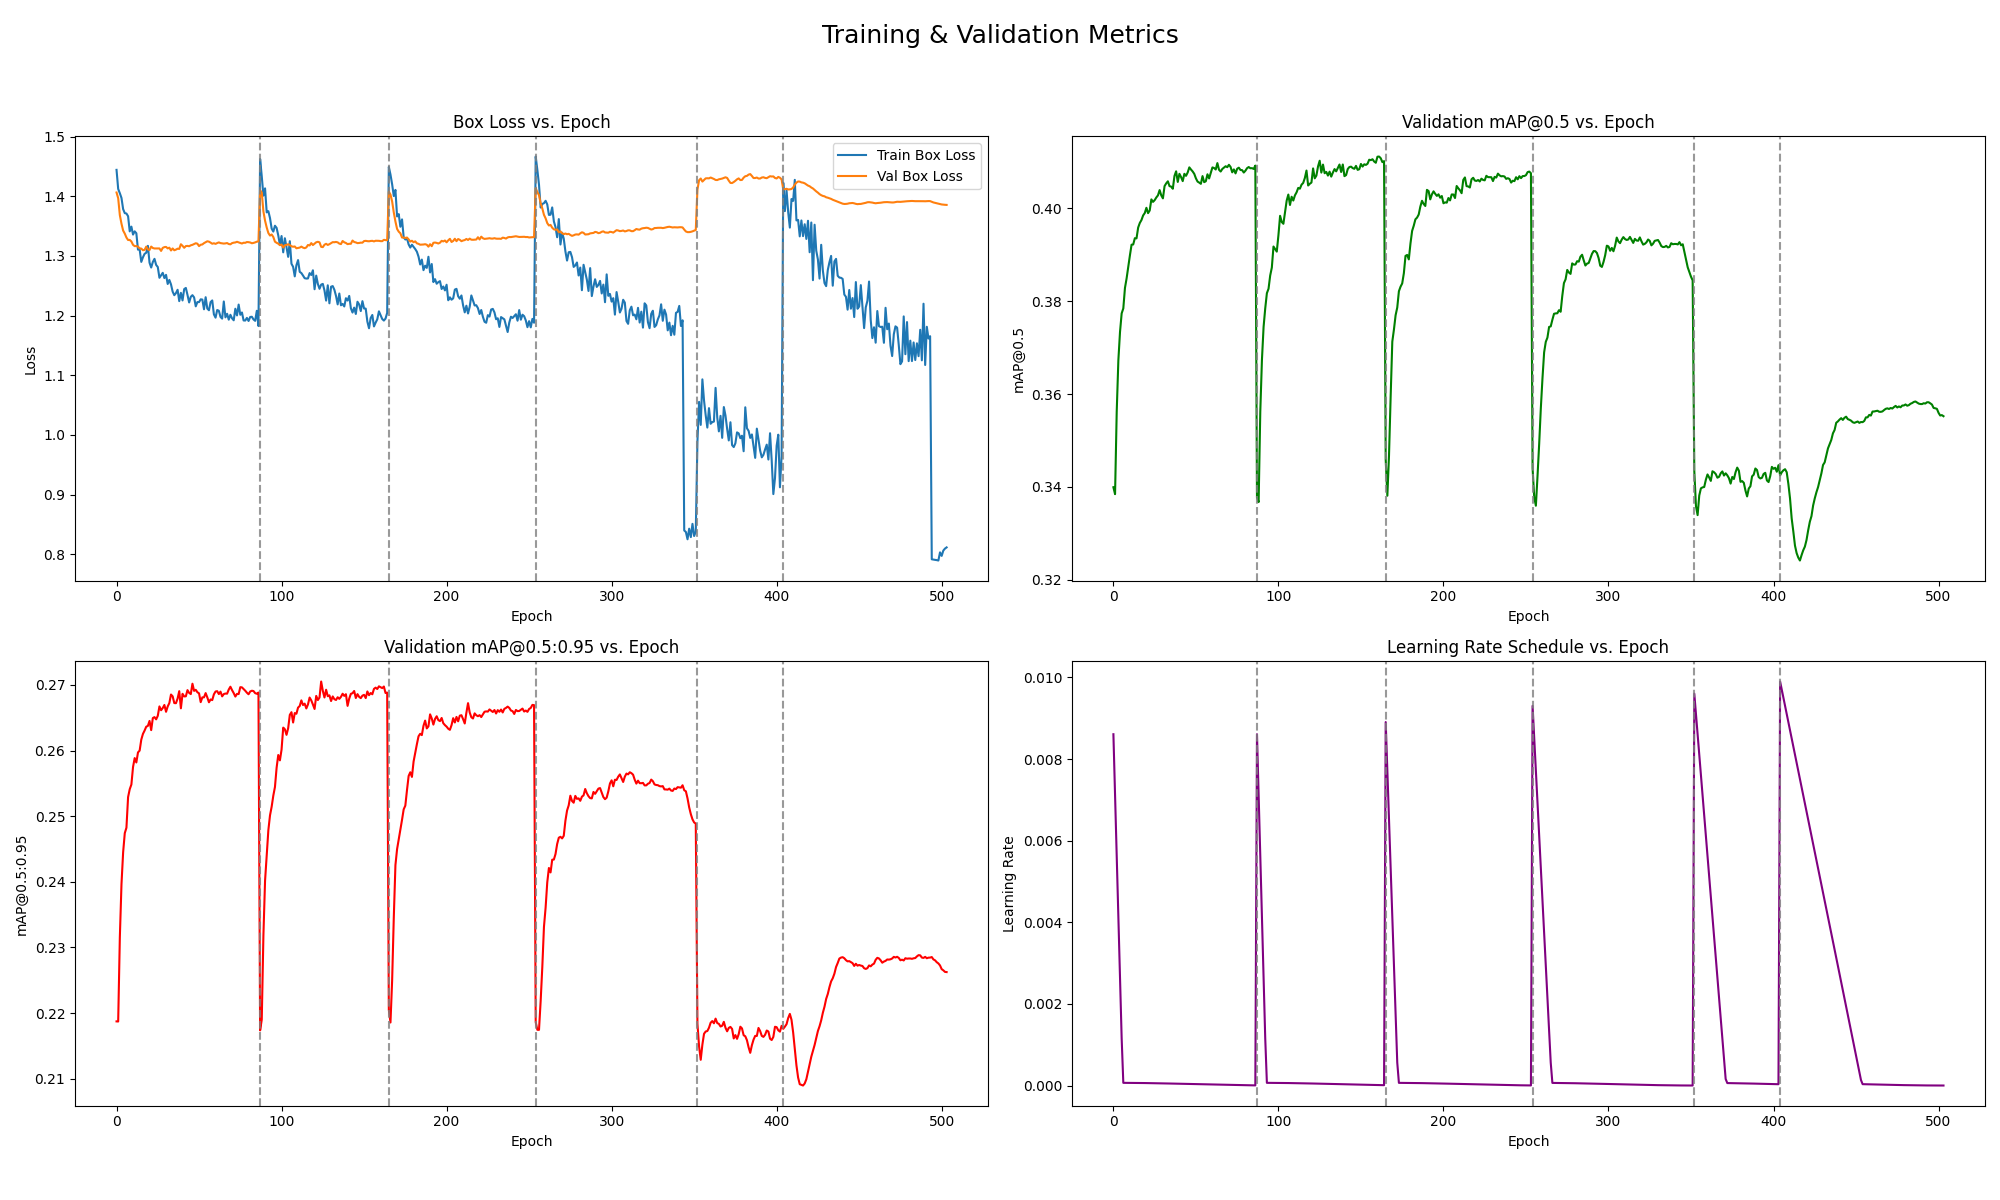

2025-09-26 08:48:55,706 - INFO - Loading final best model from Stage 2: /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/runs/task_20shot_stage2_finetune_model_phase_3/weights/best.pt
2025-09-26 08:48:55,834 - INFO - Evaluator initialized for 80 base and 5 novel classes.
2025-09-26 08:48:55,834 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 558.5±230.8 MB/s, size: 143.9 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_20_1/outputs/combined_dataset/task2/test/labels.cache... 1135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1135/1135 2.8Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10405. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 9.0s2.6ss
                   all       1135      10405      0.575      0.402      0.506      0.363
                person        582       2451      0.742      0.666       0.75      0.522
               bicycle         35         80      0.596      0.388      0.518      0.334
                   car        114        431      0.618      0.443      0.547      0.361
            motorcycle         32        101      0.792      0.416      0.633      0.375
              airplane         19         30      0.889      0.533      0.737      0.573
                   bus         34         47      0.756       0.66      0.752       0.66
                 train         24         32      0.586      0.531      0.628      0.487
                 truck         63        103      0.492      0.301      0.397      0.316
                  boat         21         74      0.583      0.378   

2025-09-26 08:49:08,000 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 08:49:08,003 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5137        0.3792  0.5058
mAP@50-95       0.3674        0.2977  0.3633
2025-09-26 08:49:08,004 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       51.37%        37.92%  50.58%
mAP@50-95       36.74%        29.77%  36.33%
2025-09-26 08:49:08,005 - INFO - ✅ Final evaluation complete.
2025-09-26 08:49:08,005 - INFO - 🖼️ Visualizing inference results on Base vs. Novel test images...
2025-09-26 08:49:08,012 - INFO - Displaying 4 samples for 'Base Image'...



0: 640x640 42 cars, 7 traffic lights, 30.7ms
1: 640x640 1 fork, 2 knifes, 2 sandwichs, 1 pizza, 1 dining table, 30.7ms
2: 640x640 1 cat, 2 backpacks, 1 handbag, 30.7ms
3: 640x640 3 cups, 1 microwave, 1 oven, 30.7ms
Speed: 1.0ms preprocess, 30.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


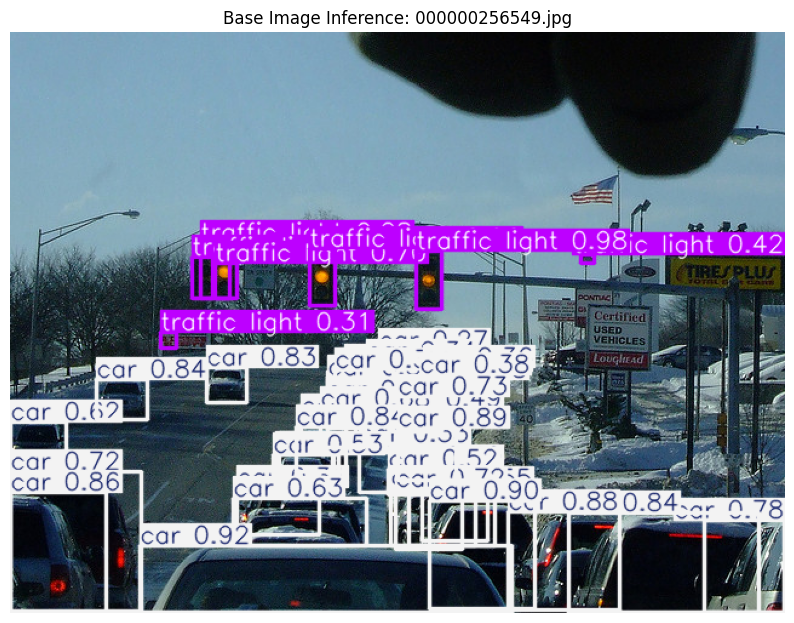

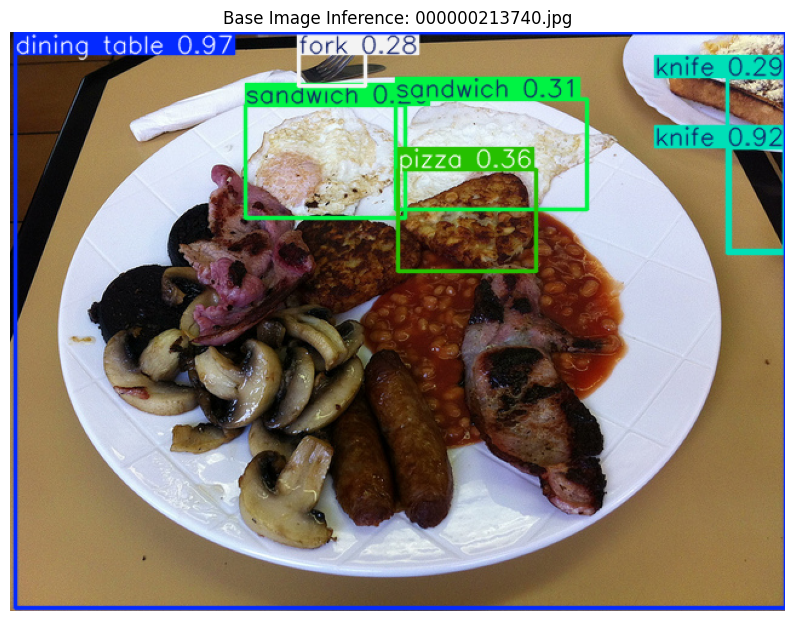

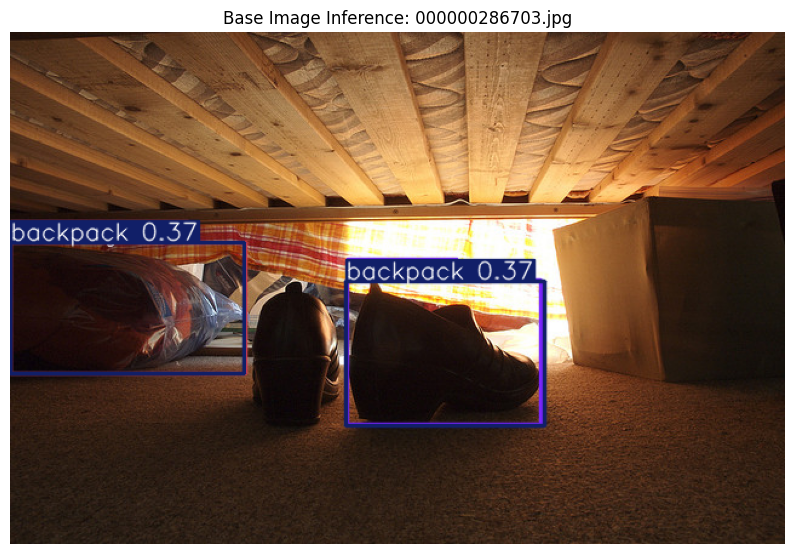

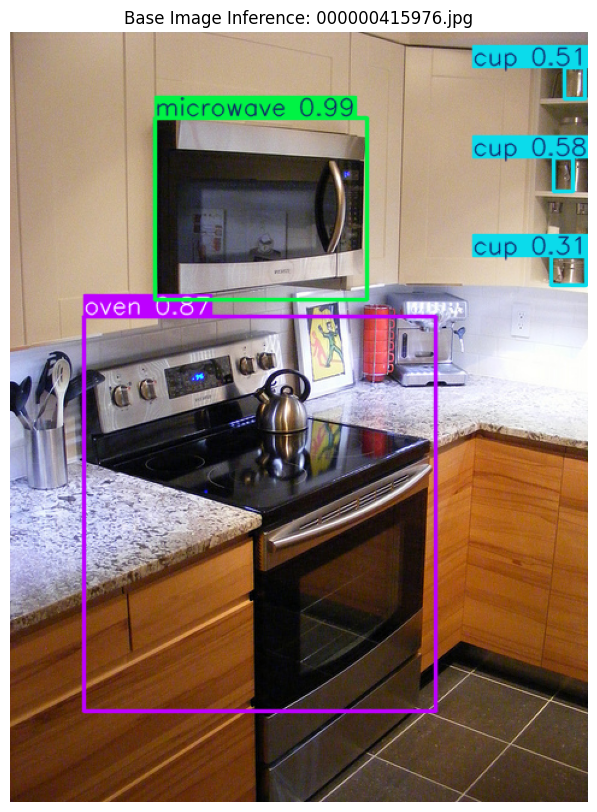

2025-09-26 08:49:09,720 - INFO - Displaying 4 samples for 'Novel Image'...



0: 640x640 1 chair, 1 couch, 1 tv, 1 vase, 1.3ms
1: 640x640 (no detections), 1.3ms
2: 640x640 2 bowls, 1 chair, 1 potted plant, 1 microwave, 1 sink, 1 vase, 1.3ms
3: 640x640 3 chairs, 2 photo frames, 1.3ms
Speed: 1.4ms preprocess, 1.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


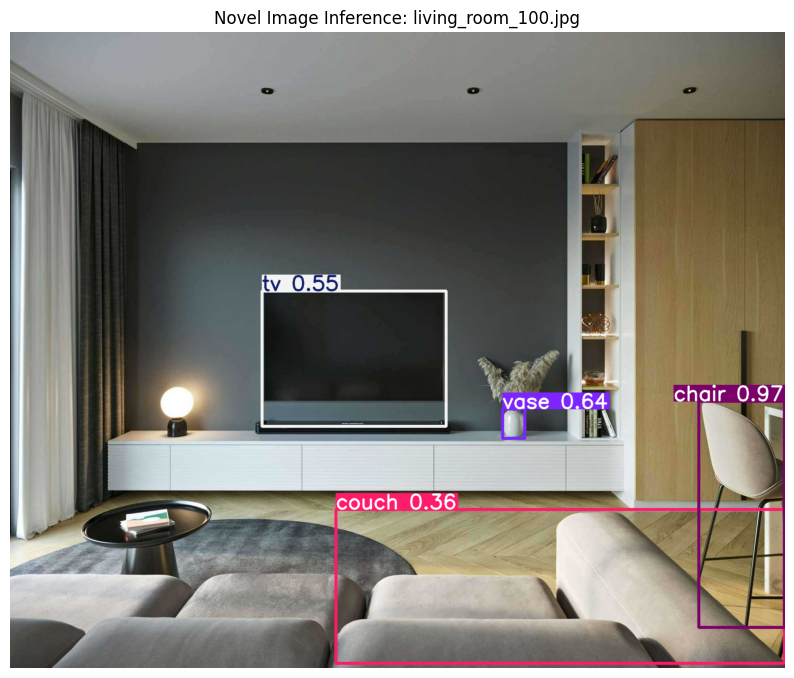

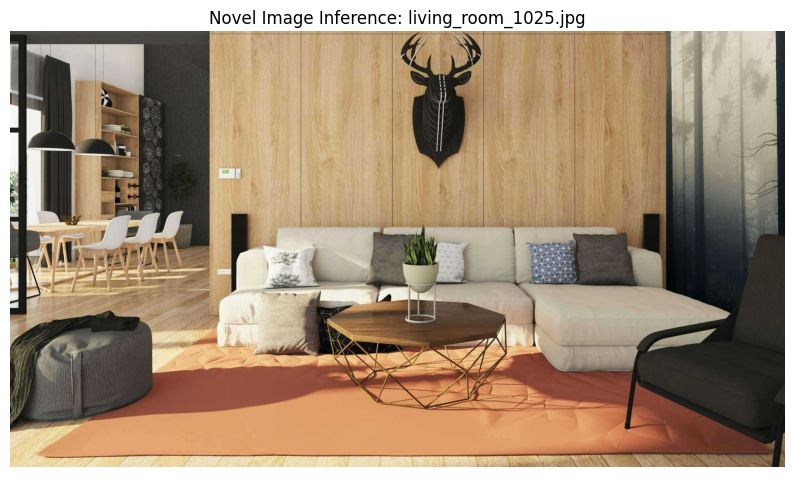

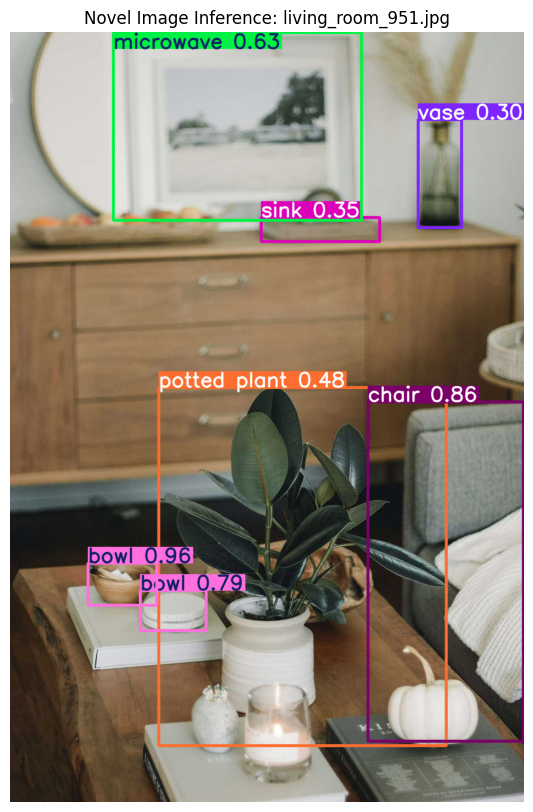

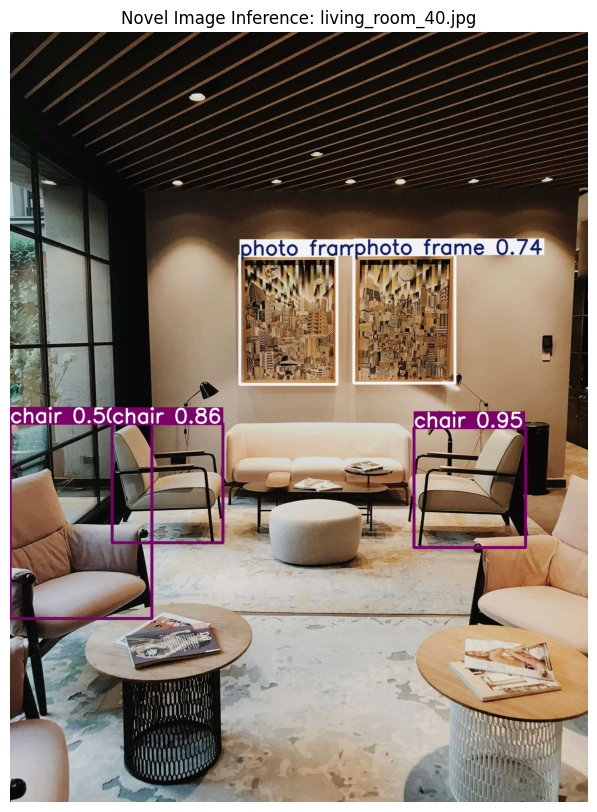

In [9]:


%matplotlib inline

logger.info("="*80)
logger.info("▶️ ANALYZING FINAL STAGE 2 RESULTS")
logger.info("="*80)

# --- Display Final Training Summary Plot ---
output_dir_s2 = Path(config_s2['output_dir'])
plot_path_s2 = output_dir_s2 / f"training_summary_plots_{config_s2['task_name']}.png"
if plot_path_s2.exists():
    logger.info(f"Displaying final training summary plot for Stage 2 from: {plot_path_s2}")
    display(IPyImage(filename=str(plot_path_s2)))
else:
    logger.warning(f"Could not find Stage 2 summary plot at {plot_path_s2}")

# --- Evaluate the Final Model ---
final_model_path = trainer_s2.overall_best_model_path
if final_model_path and final_model_path.exists():
    logger.info(f"Loading final best model from Stage 2: {final_model_path}")
    final_model_s2 = YOLO(str(final_model_path))
    
    evaluator_s2 = Evaluator(config_s2, data_manager)
    evaluator_s2.evaluate_model(final_model_s2)
    
    # --- Visualize Inference from Final Model ---
    logger.info("🖼️ Visualizing inference results on Base vs. Novel test images...")
    all_test_paths = list((data_manager.combined_data_root / "test" / "images").glob("*.*"))
    base_test_filenames = {p.name for p in (data_manager.coco_yaml_path.parent/"images"/"test").glob("*.*")}
    base_only_images = [str(p) for p in all_test_paths if p.name in base_test_filenames]
    novel_only_images = [str(p) for p in all_test_paths if p.name not in base_test_filenames]
    
    # Define the visualization function locally for completeness
    def visualize_inference_subset(model, image_paths, title_prefix, num_samples=4):
        if not image_paths:
            logger.warning(f"No images for subset: {title_prefix}"); return
        
        k = min(num_samples, len(image_paths))
        logger.info(f"Displaying {k} samples for '{title_prefix}'...")
        
        results = model.predict(source=random.sample(image_paths, k=k), conf=0.25)
        for r in results:
            im = Image.fromarray(r.plot()[..., ::-1])
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(im)
            ax.set_title(f"{title_prefix} Inference: {Path(r.path).name}"); ax.axis('off')
            plt.show()

    visualize_inference_subset(final_model_s2, base_only_images, "Base Image")
    visualize_inference_subset(final_model_s2, novel_only_images, "Novel Image")
else:
    logger.error("Could not find the best model from Stage 2.")